# Graph assembly and alignment

In [42]:
from datetime import date
from pycltools.pycltools import jprint

jprint('Adrien Leger / EMBL EBI', bold=True, size=150)
jprint('Starting date : 2020_06_04', bold=True, italic=True, size=125)
jprint('Last modification date : {}_{:02}_{:02}'.format(date.today().year, date.today().month, date.today().day), bold=True, italic=True, size=125)

## Imports 

In [43]:
# Standard lib imports
import os
from datetime import date
from collections import *
from glob import glob, iglob
from shutil import rmtree
import itertools
from pprint import pprint as pp
from tqdm import tqdm
import csv
import re

# Generic third party imports
from pycltools.pycltools import *
import pysam
import pyfaidx
import pybedtools as pbt
import pyranges as pr
import mappy as mp

# Ploting lib imports
import matplotlib.pyplot as pl
from matplotlib.colors import rgb2hex
import seaborn as sns
%matplotlib inline

# Data wrangling lib imports
import pandas as pd
import numpy as np
import scipy as sp
pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 200
pd.options.display.max_rows = 100
pd.options.display.min_rows = 100

## Get and cleanup data

### Download reference assembly

In [25]:
outdir = "./references/"
shutil.rmtree(outdir, ignore_errors=True)
mkdir(outdir)

Creating /hps/research1/birney/users/adrien/analyses/medaka_assembly_graph/graph_explore/references2


In [29]:
outdir = "./references/"
for label, link in (
    ("HDRR", "ftp://ftp.ensembl.org/pub/release-100/fasta/oryzias_latipes/dna/Oryzias_latipes.ASM223467v1.dna.toplevel.fa.gz"),
    ("HDRR+", "http://utgenome.org/medaka_v2/Medaka-Hd-rR-PacBio_unanchored_contigs.fasta.gz"),
    ("HNI", "ftp://ftp.ensembl.org/pub/release-100/fasta/oryzias_latipes_hni/dna/Oryzias_latipes_hni.ASM223471v1.dna.toplevel.fa.gz"),
    ("HNI+", "http://utgenome.org/medaka_v2/Medaka-HNI-PacBio_unanchored_contigs.fasta.gz"),
    ("HSOK", "ftp://ftp.ensembl.org/pub/release-100/fasta/oryzias_latipes_hsok/dna/Oryzias_latipes_hsok.ASM223469v1.dna.toplevel.fa.gz"),
    ("HSOK+", "http://utgenome.org/medaka_v2/Medaka-HSOK-PacBio_unanchored_contigs.fasta.gz")):
    
    print(f"Downloading and cleaning {label}")   
    zipped_fn = f"./{outdir}/Oryzias_latipes_{label}.fa.gz"
    unziped_fn = f"./{outdir}/Oryzias_latipes_{label}.fa"
    cleaned_fn = f"./{outdir}/Oryzias_latipes_{label}_clean.fa"
    
    # Download
    wget(link, zipped_fn)
    
    # Extract Gzip
    gunzip_file(zipped_fn, unziped_fn)

    # Clean up fasta names
    with open(cleaned_fn, "w") as fa_out, pyfaidx.Fasta(unziped_fn) as fa_in:
        for seq in fa_in:
            fa_out.write(f">{label}_{seq.name}\n{str(seq)}\n")

    # Index file
    with pyfaidx.Fasta(cleaned_fn) as fa:
        print(len(fa))

    # Remove originals
    for fn in [zipped_fn, unziped_fn, unziped_fn+".fai"]:
        os.remove(fn)

Downloading: ftp://ftp.ensembl.org/pub/release-100/fasta/oryzias_latipes/dna/Oryzias_latipes.ASM223467v1.dna.toplevel.fa.gz	Bytes: 223527279
100.0 MB Downloaded	[44.74 %]
200.0 MB Downloaded	[89.47 %]
223.5 MB Downloaded	[100 %]
Uncompressing ././references2//Oryzias_latipes_HDRR.fa.gz
734057086
Downloading: http://utgenome.org/medaka_v2/Medaka-Hd-rR-PacBio_unanchored_contigs.fasta.gz	Bytes: 15437627
15.4 MB Downloaded	[100 %]
Uncompressing ././references2//Oryzias_latipes_HDRR+.fa.gz
55662681
Downloading: ftp://ftp.ensembl.org/pub/release-100/fasta/oryzias_latipes_hni/dna/Oryzias_latipes_hni.ASM223471v1.dna.toplevel.fa.gz	Bytes: 207712664
100.0 MB Downloaded	[48.14 %]
200.0 MB Downloaded	[96.29 %]
207.7 MB Downloaded	[100 %]
Uncompressing ././references2//Oryzias_latipes_HNI.fa.gz
677633405
Downloading: http://utgenome.org/medaka_v2/Medaka-HNI-PacBio_unanchored_contigs.fasta.gz	Bytes: 20844315
20.8 MB Downloaded	[100 %]
Uncompressing ././references2//Oryzias_latipes_HNI+.fa.gz
7142665

In [100]:
outdir = "./references/"
for label, link in (
    ("HDRR", "ftp://ftp.ensembl.org/pub/release-100/gff3/oryzias_latipes/Oryzias_latipes.ASM223467v1.100.gff3.gz"),
    ("HNI", "ftp://ftp.ensembl.org/pub/release-100/gff3/oryzias_latipes_hni/Oryzias_latipes_hni.ASM223471v1.100.gff3.gz"),
    ("HSOK", "ftp://ftp.ensembl.org/pub/release-100/gff3/oryzias_latipes_hsok/Oryzias_latipes_hsok.ASM223469v1.100.gff3.gz")):
    
    print(f"Downloading and cleaning {label}")   
    zipped_fn = f"./{outdir}/Oryzias_latipes_{label}.gff3.gz"
    unziped_fn = f"./{outdir}/Oryzias_latipes_{label}.gff3"
    cleaned_fn = f"./{outdir}/Oryzias_latipes_{label}_clean.gff3"
    sorted_fn = f"./{outdir}/Oryzias_latipes_{label}_sorted.gff3"
    
    # Download
    wget(link, zipped_fn)
    # Extract Gzip
    gunzip_file(zipped_fn, unziped_fn)
    
    # Clean fasta names
    with open(unziped_fn, "r") as gff_in, open(cleaned_fn, "w") as gff_out:
        for line in gff_in:
            line = line.strip()
            
            if line.startswith("##sequence-region"):
                line = line.split()
                line[1] = "{}_{}".format(label, line[1])
                line = "\t".join(line)
            if line[0] != "#":
                line = line.split()
                line[0] = "{}_{}".format(label, line[0])
                line = "\t".join(line)
            gff_out.write(line+"\n")
        
    # Sort and index for IGV
    bash (f"igvtools sort {cleaned_fn} {sorted_fn}", conda="IGV")
    bash (f"igvtools index {sorted_fn}", conda="IGV")

    # Remove originals
    os.remove(zipped_fn)
    os.remove(unziped_fn)
    os.remove(cleaned_fn)

Downloading: ftp://ftp.ensembl.org/pub/release-100/gff3/oryzias_latipes/Oryzias_latipes.ASM223467v1.100.gff3.gz	Bytes: 12175696
12.2 MB Downloaded	[100 %]
Uncompressing ././references2//Oryzias_latipes_HDRR.gff3.gz
Using system JDK.
WARN [2020-07-08T12:21:07,324]  [Globals.java:138] [main]  Development mode is enabled
Sorting ././references2//Oryzias_latipes_HDRR_clean.gff3  -> ././references2//Oryzias_latipes_HDRR_sorted.gff3
Done
Using system JDK.
WARN [2020-07-08T12:21:17,035]  [Globals.java:138] [main]  Development mode is enabled
Done
Downloading: ftp://ftp.ensembl.org/pub/release-100/gff3/oryzias_latipes_hni/Oryzias_latipes_hni.ASM223471v1.100.gff3.gz	Bytes: 11436936
11.4 MB Downloaded	[100 %]
Uncompressing ././references2//Oryzias_latipes_HNI.gff3.gz
Using system JDK.
WARN [2020-07-08T12:21:28,959]  [Globals.java:138] [main]  Development mode is enabled
Sorting ././references2//Oryzias_latipes_HNI_clean.gff3  -> ././references2//Oryzias_latipes_HNI_sorted.gff3
Done
Using system 

### Merge all fasta ref together

In [43]:
references_list = [
    './references/Oryzias_latipes_HDRR_clean.fa',
    './references/Oryzias_latipes_HDRR+_clean.fa',
    './references/Oryzias_latipes_HNI_clean.fa',
    './references/Oryzias_latipes_HNI+_clean.fa',
    './references/Oryzias_latipes_HSOK_clean.fa',
    './references/Oryzias_latipes_HSOK+_clean.fa']
alternative_list = glob.glob("./individual_assemblies/*_clean.fa")
all_ref = references_list+alternative_list

out_fn = "references/Oryzias_latipes_all_assemblies_contig.fa"

with open (out_fn, "w") as fa_out:
    for fasta_fn in all_ref:
        print(f"Copy {fasta_fn}")
        with open(fasta_fn,'r') as fa_in:
            shutil.copyfileobj(fa_in, fa_out)

with pyfaidx.Fasta(out_fn) as fa:
    print(len(fa))

Copy ./references2/Oryzias_latipes_HDRR_clean.fa
Copy ./references2/Oryzias_latipes_HDRR+_clean.fa
Copy ./references2/Oryzias_latipes_HNI_clean.fa
Copy ./references2/Oryzias_latipes_HNI+_clean.fa
Copy ./references2/Oryzias_latipes_HSOK_clean.fa
Copy ./references2/Oryzias_latipes_HSOK+_clean.fa
Copy ./individual_assemblies/69-1_F3_clean.fa
Copy ./individual_assemblies/131-1_F4_clean.fa
Copy ./individual_assemblies/117-2_C4_clean.fa
Copy ./individual_assemblies/4-2_B2_clean.fa
Copy ./individual_assemblies/7-2_F2_clean.fa
Copy ./individual_assemblies/4-1_B2_clean.fa
Copy ./individual_assemblies/134-2_A5_clean.fa
Copy ./individual_assemblies/79-2_G3_clean.fa
Copy ./individual_assemblies/134-1_H4_clean.fa
Copy ./individual_assemblies/80-1_H3_clean.fa
Copy ./individual_assemblies/7-1_E2_clean.fa
Copy ./individual_assemblies/11-1_A3_clean.fa
11123476255


### Merge all annotations together

In [102]:
gff_list = [
    './references/Oryzias_latipes_HDRR_sorted.gff3',
    './references/Oryzias_latipes_HNI_sorted.gff3',
    './references/Oryzias_latipes_HSOK_sorted.gff3']

out_fn = "references/Oryzias_latipes_all_assemblies.gff3"
out_fn_sorted = "references/Oryzias_latipes_all_assemblies_sorted.gff3"

with open (out_fn, "w") as gff_out:
    gff_out.write("##gff-version 3\n")
    
    print(f"Copy headers")
    for gff_fn in gff_list:
        with open (gff_fn) as gff_fp: 
            for line in gff_fp:
                line = line.strip()
                if line.startswith("##sequence-region"):
                    gff_out.write(f"{line}\n")
                elif not line.startswith("#"):
                    break
    print(f"Copy annotations")
    for gff_fn in gff_list:
        with open (gff_fn) as gff_fp: 
            for line in gff_fp:
                line = line.strip()
                if not line.startswith("#"):
                    gff_out.write(f"{line}\n")

# Sort and index for IGV
print(f"Sort and index with igvtools")
bash (f"igvtools sort {out_fn} {out_fn_sorted}", conda="IGV")
bash (f"igvtools index {out_fn_sorted}", conda="IGV")

# Remove originals
os.remove(out_fn)

Copy headers
Copy annotations
Sort and index with igvtools
Using system JDK.
WARN [2020-07-08T12:22:18,467]  [Globals.java:138] [main]  Development mode is enabled
Sorting references2/Oryzias_latipes_all_assemblies.gff3  -> references2/Oryzias_latipes_all_assemblies_sorted.gff3
Done
Using system JDK.
WARN [2020-07-08T12:22:40,152]  [Globals.java:138] [main]  Development mode is enabled
Done


### Merge RNAseq Paired end

In [163]:
outdir = "./rna_seq_data"
shutil.rmtree(outdir, ignore_errors=True)
mkdir(outdir)

info_fn = "/hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/Analysis_low_high/candidates/liver_candidate_rep1.tsv"

sample_d = OrderedDict()
with open(info_fn) as csvfile:
    reader = csv.DictReader(csvfile, delimiter='\t')
    for row in reader:
        sample_d[row["sanger_id"]] = row["sample_id"].replace("_", "-")
sample_d

for sanger_id, sample_id in sample_d.items():
    R1 = f"/hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/fastp/high_{sanger_id}_1.fastq.gz"
    R2 = f"/hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/fastp/high_{sanger_id}_2.fastq.gz"
    
    if os.path.isfile(R1) and os.path.isfile(R2):
        stdout = f"{outdir}/{sample_id}_flash.err"
        stderr = f"{outdir}/{sample_id}_flash.out"
    
        cmd = f"flash {R1} {R2} -r 150 -f 220 --output-prefix {sample_id}_merged --output-directory {outdir} --compress --threads 20"
        _ = bsub(cmd, conda="flash", dry=False, mem=5000, threads=20, stdout_fp=stdout, stderr_fp=stderr)

Creating /hps/research1/birney/users/adrien/analyses/medaka_assembly_graph/graph_explore/rna_seq_data
bsub -M 5000 -R 'rusage[mem=5000]' -n 20 -oo ./rna_seq_data/104-1_flash.err -eo ./rna_seq_data/104-1_flash.out  "flash /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/fastp/high_5093STDY7225690_1.fastq.gz /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/fastp/high_5093STDY7225690_2.fastq.gz -r 150 -f 220 --output-prefix 104-1_merged --output-directory ./rna_seq_data --compress --threads 20"
Job <1372430> is submitted to default queue <research-rh74>.
bsub -M 5000 -R 'rusage[mem=5000]' -n 20 -oo ./rna_seq_data/106-1_flash.err -eo ./rna_seq_data/106-1_flash.out  "flash /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/fastp/high_5093STDY7223970_1.fastq.gz /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumin

Job <1372460> is submitted to default queue <research-rh74>.
bsub -M 5000 -R 'rusage[mem=5000]' -n 20 -oo ./rna_seq_data/139-4_flash.err -eo ./rna_seq_data/139-4_flash.out  "flash /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/fastp/high_5093STDY7225306_1.fastq.gz /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/fastp/high_5093STDY7225306_2.fastq.gz -r 150 -f 220 --output-prefix 139-4_merged --output-directory ./rna_seq_data --compress --threads 20"
Job <1372471> is submitted to default queue <research-rh74>.
bsub -M 5000 -R 'rusage[mem=5000]' -n 20 -oo ./rna_seq_data/13-2_flash.err -eo ./rna_seq_data/13-2_flash.out  "flash /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/fastp/high_5093STDY7223514_1.fastq.gz /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/inpu

Job <1372494> is submitted to default queue <research-rh74>.
bsub -M 5000 -R 'rusage[mem=5000]' -n 20 -oo ./rna_seq_data/40-2_flash.err -eo ./rna_seq_data/40-2_flash.out  "flash /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/fastp/high_5093STDY7225858_1.fastq.gz /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/fastp/high_5093STDY7225858_2.fastq.gz -r 150 -f 220 --output-prefix 40-2_merged --output-directory ./rna_seq_data --compress --threads 20"
Job <1372495> is submitted to default queue <research-rh74>.
bsub -M 5000 -R 'rusage[mem=5000]' -n 20 -oo ./rna_seq_data/49-1_flash.err -eo ./rna_seq_data/49-1_flash.out  "flash /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/fastp/high_5093STDY7223458_1.fastq.gz /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/f

Job <1372515> is submitted to default queue <research-rh74>.
bsub -M 5000 -R 'rusage[mem=5000]' -n 20 -oo ./rna_seq_data/84-2_flash.err -eo ./rna_seq_data/84-2_flash.out  "flash /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/fastp/high_5093STDY7222946_1.fastq.gz /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/fastp/high_5093STDY7222946_2.fastq.gz -r 150 -f 220 --output-prefix 84-2_merged --output-directory ./rna_seq_data --compress --threads 20"
Job <1372516> is submitted to default queue <research-rh74>.
bsub -M 5000 -R 'rusage[mem=5000]' -n 20 -oo ./rna_seq_data/8-2_flash.err -eo ./rna_seq_data/8-2_flash.out  "flash /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/fastp/high_5093STDY7223834_1.fastq.gz /hps/research1/birney/users/adrien/analyses/medaka_RNA_illumina/Indigene_pilot/RNA_pipeline2/results/input/fas

## Graph Assembly

### Generate graph

In [45]:
outdir = "./graph_assembly"
#shutil.rmtree(outdir, ignore_errors=True)
mkdir(outdir)

mem = 60000
threads = 20
dry = False

references_list = [
    './references/Oryzias_latipes_HDRR_clean.fa',
    './references/Oryzias_latipes_HDRR+_clean.fa',
    './references/Oryzias_latipes_HNI_clean.fa',
    './references/Oryzias_latipes_HNI+_clean.fa',
    './references/Oryzias_latipes_HSOK_clean.fa',
    './references/Oryzias_latipes_HSOK+_clean.fa']

alternative_list = glob.glob("./individual_assemblies/*_clean.fa")
all_ref = " ".join(references_list+alternative_list)

gfa = f"{outdir}/all_ref_graph.gfa"
 

bsub -M 60000 -R 'rusage[mem=60000]' -n 20 -oo ./graph_assembly2/all_ref_graph.err -eo ./graph_assembly2/all_ref_graph.out -P bigmem  "minigraph -x ggs -L 100 -t 20 ./references2/Oryzias_latipes_HDRR_clean.fa ./references2/Oryzias_latipes_HDRR+_clean.fa ./references2/Oryzias_latipes_HNI_clean.fa ./references2/Oryzias_latipes_HNI+_clean.fa ./references2/Oryzias_latipes_HSOK_clean.fa ./references2/Oryzias_latipes_HSOK+_clean.fa ./individual_assemblies/69-1_F3_clean.fa ./individual_assemblies/131-1_F4_clean.fa ./individual_assemblies/117-2_C4_clean.fa ./individual_assemblies/4-2_B2_clean.fa ./individual_assemblies/7-2_F2_clean.fa ./individual_assemblies/4-1_B2_clean.fa ./individual_assemblies/134-2_A5_clean.fa ./individual_assemblies/79-2_G3_clean.fa ./individual_assemblies/134-1_H4_clean.fa ./individual_assemblies/80-1_H3_clean.fa ./individual_assemblies/7-1_E2_clean.fa ./individual_assemblies/11-1_A3_clean.fa > ./graph_assembly2/all_ref_graph.gfa"
Job <3595722> is submitted to default q

'3595722'

In [17]:
bjobs(cmd = "minigraph -x ggs*")

,jobid,user,status,queue,cmd,cpu_used,mem,swap,submit_time,start_time


###  Display L and S lines

In [55]:
graph_fn = "./graph_assembly/all_ref_graph.gfa"
seg_line = namedtuple("S", ["seg_id", "sequence", "length", "chromosome", "start", "rank"])
seg_line_list = []
link_line = namedtuple("L", ["seg1_id", "seg1_orient", "seg2_id", "seg2_orient", "cigar", "rank", "seg1_length", "seg2_length"])
link_line_list = []

with open (graph_fn) as fp:
    for l in tqdm(fp):
        l = l.strip().split("\t")
        
        if l[0] == "S":
            sl = seg_line(l[1], l[2], int(l[3].split(":")[-1]), l[4].split(":")[-1], int(l[5].split(":")[-1]), int(l[6].split(":")[-1]))
            seg_line_list.append(sl)
            
        if l[0] == "L":
            ll = link_line(l[1], l[2], l[3], l[4], l[5], int(l[6].split(":")[-1]), int(l[7].split(":")[-1]), int(l[8].split(":")[-1]))
            link_line_list.append(ll)

seg_df = pd.DataFrame(seg_line_list)
link_df = pd.DataFrame(link_line_list)

with pd.option_context("display.max_colwidth", 50):
    display(seg_df.sample(10))
    display(link_df.sample(10))

2632099it [00:19, 132149.83it/s]


,seg_id,sequence,length,chromosome,start,rank
821800,s821801,GCAATGGTCTTCTTAAATTAAATATAAAAAATGCTTCTGTTAATGT...,130,HSOK_6,30064625,4
251827,s251828,GGTGTTTGAACTGAAACCAATAAACAAACACAGAAGAGCATAGCCC...,393,HDRR_9,26206200,0
298378,s298379,TTTTTTACATTTAAAAAGATCCCTTTCTTCCTTTGTTTTTCTTTAC...,1897,HDRR_11,10968366,0
892662,s892663,TGTATCATTGACTTTTATTGTTTTTAATTTAATTCACTGCTGGATG...,789,HSOK_23,17815495,4
1002558,s1002559,TATATTGAATATTACACAATTATGAACCATCGTTTTTTATGAGGTA...,1507,MIKK_4-2_B2_31,2625342,9
104816,s104817,ATTTTTCTTGTAATCCAGTGTTTCGCATGCTGAGCAACAAGTTAGT...,8528,HDRR_4,15077549,0
589473,s589474,TTTTGTAACTCCAATGAGGAAACGCTGGAACATGT,35,HDRR_22,11141139,0
671705,s671706,GAGCTGATCT,10,HNI_4,20085113,2
839896,s839897,ATATTGTTCATAGTAAACAGTTGTGATGCCACAATATTTTTTTGTT...,150,HSOK_10,30662802,4
55664,s55665,AAACAAGGTTGGGAGGCAAG,20,HDRR_2,22077791,0


,seg1_id,seg1_orient,seg2_id,seg2_orient,cigar,rank,seg1_length,seg2_length
871255,s551323,+,s551324,+,0M,0,281,20
244930,s154994,+,s154995,+,0M,0,1348,333
235909,s149318,+,s681559,+,0M,2,265,104
940601,s595221,+,s889201,+,0M,4,412,361
1284299,s892636,+,s622135,+,0M,4,1823,2278
476208,s301259,+,s301260,+,0M,0,4115,367
343863,s217531,+,s217532,+,0M,0,101,8382
1174003,s785555,+,s785556,+,0M,2,191,95
315979,s199891,+,s199892,+,0M,0,2814,17
106632,s67543,+,s992867,+,0M,8,2165,710


### Parse graph segments

#### Define helper functions

In [24]:
Coord = namedtuple("coord", ["chromosome", "start", "end", "start_seg_id", "end_seg_id"])

def find_connected_ref (seg_id, seg_info_d, path=None, reference_type="HDRR"):
    seg_info = seg_info_d[seg_id]
    
    # if leaf is ref type return coordinates
    if seg_info["type"] == reference_type:
        return Coord(seg_info["chromosome"], seg_info["end"], seg_info["start"], seg_id, seg_id)
    
    # Add any visited node to the path
    if not path:
        path = []
    path.append(seg_id)
     
    best_chromosome = best_start = best_end = best_start_seg_id = best_end_seg_id = None
    for s in seg_info["connected"]:
        
        # Avoid circular paths error
        if not s in path:
            
            # Recursively search for connected segments 
            coord = find_connected_ref(seg_id=s, seg_info_d=seg_info_d, path=path)
            
            if coord.chromosome and coord.start and coord.end:
                if not best_chromosome:
                    best_chromosome = coord.chromosome
                else:
                    assert best_chromosome == coord.chromosome
                if not best_end or coord.end > best_end:
                        best_end = coord.end
                        best_end_seg_id = coord.end_seg_id
                if not best_start or coord.start < best_start:
                        best_start = coord.start
                        best_start_seg_id = coord.start_seg_id
                        
    return Coord(best_chromosome, best_start, best_end, best_start_seg_id, best_end_seg_id)

def sort_seg (s1, s2, s1_orient, s2_orient):
    """"""
    s1_num = int(s1[1:])
    s2_num = int(s2[1:])
    if s1_num > s2_num:
        inv_dict = {"+":"-", "-":"+"}
        s1, s2 = s2, s1
        s1_orient, s2_orient = inv_dict[s2_orient], inv_dict[s1_orient]
        
    return (s1, s2, s1_orient, s2_orient)

def get_link_info(s1_orient, s2_orient, s1_info, s2_info):
    """"""
    s1_chromosome = s1_info["chromosome"]
    s1_pos = s1_info["end"] if s1_orient == "+" else s1_info["start"]
    s1_type = s1_info["type"]
    
    s2_chromosome = s2_info["chromosome"]
    s2_pos = s2_info["start"] if s2_orient == "+" else s2_info["end"]
    s2_type = s2_info["type"]
    
    if s1_chromosome == s2_chromosome:
        connect_type = "intra_{}".format(s1_type)
        
        # Calculate length of break point
        connect_gap = s2_pos-s1_pos if s1_orient == "+" else s1_pos-s2_pos
        
        # Define type of jump depending on break length 
        if s1_orient == s2_orient:
            if connect_gap==0:
                SV_type = "continuous"
            elif connect_gap>0:
                SV_type = "deletion"
            else:
                SV_type = "duplication"
        else:
            SV_type = "invertion"
    elif s1_type == s2_type:
        connect_type = "inter_{}".format(s1_type)
        connect_gap = None
        SV_type = "insertion"
    else:
        connect_type = "{}_{}".format(s1_type, s2_type)
        connect_gap = None
        SV_type = "insertion"
    
    d = OrderedDict(
        s1_chromosome = s1_chromosome,
        s1_pos = s1_pos,
        s2_chromosome = s2_chromosome,
        s2_pos = s2_pos,
        s2_type = s2_type,
        connect_type = connect_type,
        connect_gap = connect_gap,
        SV_type = SV_type)
    return d

#### Parse graph

In [26]:
graph_fn = "./graph_assembly/all_ref_graph.gfa"
main_ref_fasta = "./references/Oryzias_latipes_HDRR_clean.fa"
seg_info_out_fn = "./graph_assembly/all_ref_graph_seg_info.pkl"
link_info_out_fn = "./graph_assembly/all_ref_graph_link_info.pkl"
graph_segments_fasta = "./graph_assembly/Oryzias_latipes_graph_segments.fa"

link_info_d = OrderedDict()
seg_info_d = OrderedDict()
max_comp = 0
min_len_align = 200
ref_label = "HDRR"

# Align remaining segments to reference to define identity
stdout_print("Make minimap db\n")
minimap_db = mp.Aligner(main_ref_fasta, best_n=1, scoring=(2,4,4,2,24,0), k=15, n_threads=10)

stdout_print("Annotate segments and links\n")
with open(graph_fn) as graph_fp, open(graph_segments_fasta, "w") as fasta_fp:
    for l in tqdm(graph_fp):
        l = l.strip().split("\t")
        
        if l[0] == "S":
            seg_id = l[1]
            seq =l[2]
            chromosome = l[4].split(":")[-1]
            length = int(l[3].split(":")[-1])
            start = int(l[5].split(":")[-1])
            end = start+length
            seg_type = chromosome.split("_")[0]
            
            # Write segment sequences to fasta
            fasta_fp.write(f">{seg_id}\n{seq}\n")

            # Try to align to ref if long enough
            if seg_type != ref_label and length >= min_len_align:
                seq = l[2]
                hits = minimap_db.map(seq=seq)
                try:
                    hit = next(hits)
                    soft_clip = hit.q_st+(length-hit.q_en)
                    identity = (hit.blen-hit.NM)/(hit.blen+soft_clip)
                    hit_chromosome, hit_start, hit_end = hit.ctg, hit.r_st, hit.r_en
                except StopIteration:
                    identity = 0
                    hit_chromosome = hit_start = hit_end = None
                finally:
                    del hits
                
            else:
                identity = None
                hit_chromosome = hit_start = hit_end = None
                
            seg_info_d[seg_id] = OrderedDict(
                chromosome = chromosome,
                start = start,
                end = end,
                length = length,
                type = seg_type,
                identity = identity,
                hit_chromosome = hit_chromosome,
                hit_start = hit_start,
                hit_end = hit_end,
                component = 0,
                connected = [])
        
        # Record all possible connections between segments
        if l[0] == "L":
            
            # Sort and flip segments if 
            s1, s2, s1_orient, s2_orient = sort_seg (s1=l[1], s2=l[3], s1_orient=l[2], s2_orient=l[4]) 
            s1_info=seg_info_d[s1]
            s2_info=seg_info_d[s2]
            
            # Characterise junctions type
            link_info = get_link_info(s1_orient=s1_orient, s2_orient=s2_orient, s1_info=s1_info, s2_info=s2_info)
            link_id = "{}{}_{}{}".format(s1, s1_orient, s2, s2_orient)
            link_info_d[link_id] = link_info
            
            # Update list of connected segments
            seg_info_d[s2]["connected"].append(s1)
            seg_info_d[s1]["connected"].append(s2)
            
            # Determine component the pair belongs to
            s1_comp = s1_info["component"]
            s2_comp = s2_info["component"]
            if not s1_comp and not s2_comp:
                max_comp+=1
                seg_info_d[s1]["component"] = max_comp
                seg_info_d[s2]["component"] = max_comp
            elif not s1_comp:
                seg_info_d[s1]["component"] = s2_comp
            elif not s2_comp:
                seg_info_d[s2]["component"] = s1_comp
            else:
                assert s1_comp == s2_comp

del minimap_db                

# Find connected reference coordinate 
stdout_print("Traverse graph to find reference anchor points\n")
for seg_id, seg_info in tqdm(seg_info_d.items()):
    if seg_info["type"] != ref_label:
        coord = find_connected_ref(seg_id=seg_id, seg_info_d=seg_info_d, reference_type=ref_label)
        seg_info_d[seg_id]["connected_chromosome"] = coord.chromosome
        seg_info_d[seg_id]["connected_start"] = coord.start
        seg_info_d[seg_id]["connected_end"] = coord.end
        seg_info_d[seg_id]["connected_seg_start"] = coord.start_seg_id
        seg_info_d[seg_id]["connected_seg_end"] = coord.end_seg_id

seg_info_df = pd.DataFrame.from_dict(seg_info_d, orient="index")
seg_info_df.index.name = "seg_id"
seg_info_df.to_pickle(seg_info_out_fn)
display(seg_info_df.head())

link_info_df = pd.DataFrame.from_dict(link_info_d, orient="index")
link_info_df.index.name = "link_id"
link_info_df.to_pickle(link_info_out_fn)
display(link_info_df.head())

Make minimap db
Annotate segments and links


2632099it [1:06:48, 656.59it/s]   


Traverse graph to find reference anchor points


100%|██████████| 1109492/1109492 [00:12<00:00, 87690.43it/s] 


,chromosome,start,end,length,type,identity,hit_chromosome,hit_start,hit_end,component,connected,connected_chromosome,connected_start,connected_end,connected_seg_start,connected_seg_end
seg_id,,,,,,,,,,,,,,,,
s1,HDRR_1,0,37816,37816,HDRR,NaN,None,NaN,NaN,1,"[s2, s1044544]",NaN,NaN,NaN,NaN,NaN
s2,HDRR_1,37816,37928,112,HDRR,NaN,None,NaN,NaN,1,"[s1, s3, s999575]",NaN,NaN,NaN,NaN,NaN
s3,HDRR_1,37928,40172,2244,HDRR,NaN,None,NaN,NaN,1,"[s2, s4]",NaN,NaN,NaN,NaN,NaN
s4,HDRR_1,40172,41595,1423,HDRR,NaN,None,NaN,NaN,1,"[s3, s5, s999575]",NaN,NaN,NaN,NaN,NaN
s5,HDRR_1,41595,50707,9112,HDRR,NaN,None,NaN,NaN,1,"[s4, s6, s1044544, s999574]",NaN,NaN,NaN,NaN,NaN


,s1_chromosome,s1_pos,s2_chromosome,s2_pos,s2_type,connect_type,connect_gap,SV_type
link_id,,,,,,,,
s1+_s2+,HDRR_1,37816,HDRR_1,37816,HDRR,intra_HDRR,0.0,continuous
s2+_s3+,HDRR_1,37928,HDRR_1,37928,HDRR,intra_HDRR,0.0,continuous
s3+_s4+,HDRR_1,40172,HDRR_1,40172,HDRR,intra_HDRR,0.0,continuous
s4+_s5+,HDRR_1,41595,HDRR_1,41595,HDRR,intra_HDRR,0.0,continuous
s4-_s999575+,HDRR_1,40172,MIKK_117-2_C4_959,161190,MIKK,HDRR_MIKK,NaN,insertion


### Extract stats from segments

,Total length (bp),Segments number,Median segment length,longest segment,N50,Median identity
HDRR,734100826,648692,401.0,675459,3000,0.960224
HNI,103507879,148689,239.0,175667,2003,0.629009
HSOK,152043332,100275,371.0,236527,5803,0.604474
MIKK,318174656,211836,559.0,89792,3998,0.736830
All,1307826693,1109492,389.0,675459,3342,0.683020


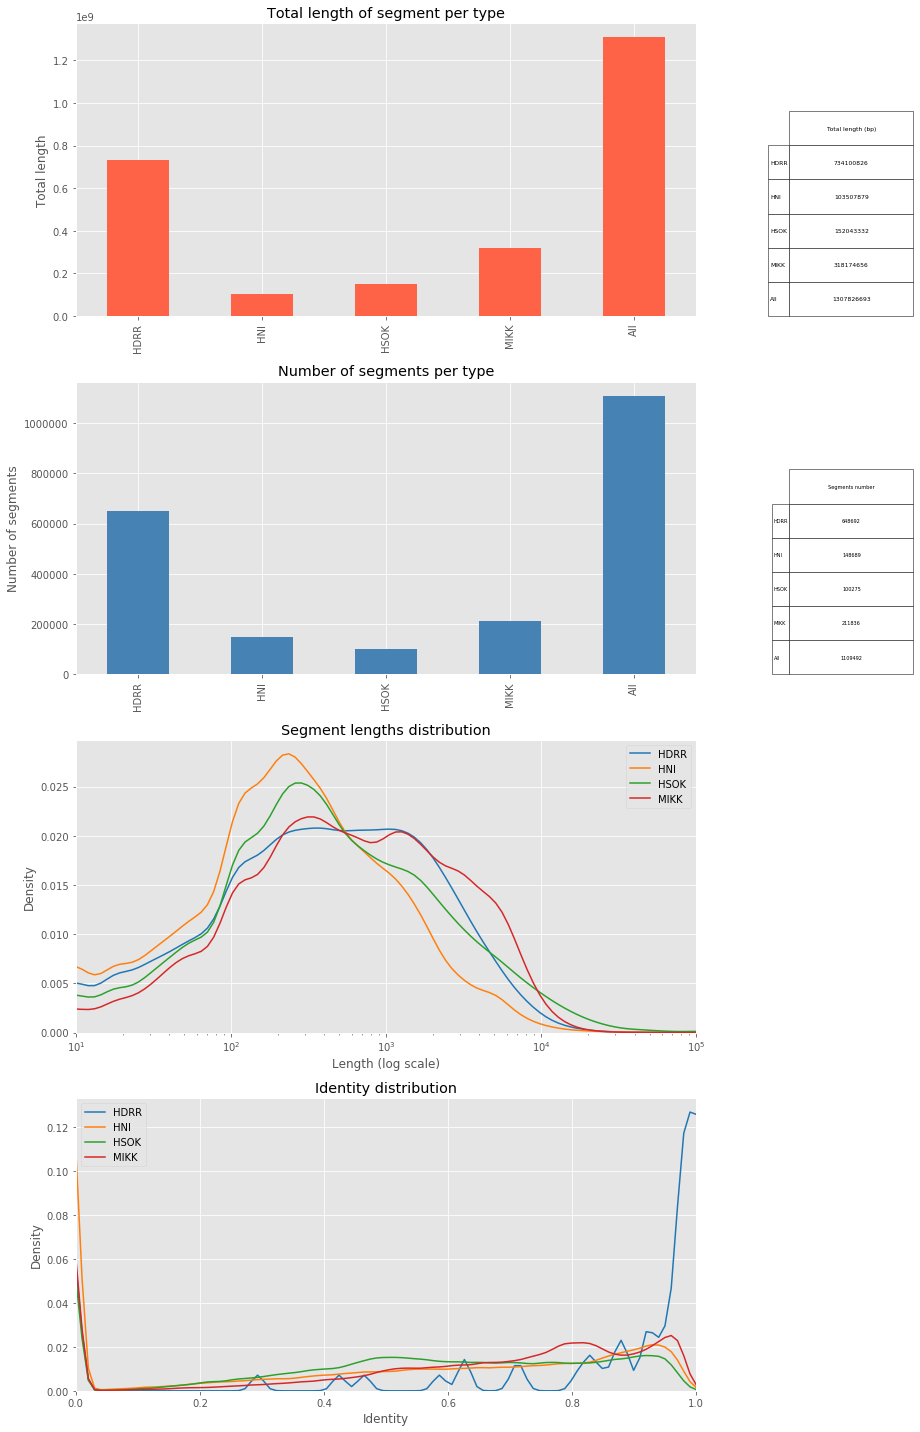

In [303]:
from pandas.plotting import table
from scipy.ndimage import gaussian_filter1d

def compute_N50 (data):
    data = data.dropna().values
    data.sort()
    half_sum = data.sum()/2
    cum_sum = 0
    for v in data:
        cum_sum += v
        if cum_sum >= half_sum:
            return int(v)

graph_info_fn="./graph_assembly/all_ref_graph_seg_info.pkl"
outdir="./graph_assembly/"

seg_type_info = defaultdict(OrderedDict)
seg_type_identity_list = OrderedDict()
seg_type_len_list = OrderedDict()

df = pd.read_pickle(graph_info_fn)
df = df[["length","type","identity"]]

# Aggregate unanchore contigs
df["type"] = df["type"].str.rstrip("+")

for seg_type, sdf in df.groupby("type"):
    seg_type_info[seg_type]["Total length (bp)"] = sdf["length"].sum()
    seg_type_info[seg_type]["Segments number"] = len(sdf)
    seg_type_info[seg_type]["Median segment length"] = sdf["length"].dropna().median()
    seg_type_info[seg_type]["longest segment"] = sdf["length"].dropna().max()
    seg_type_info[seg_type]["N50"] = compute_N50 (sdf["length"])
    seg_type_info[seg_type]["Median identity"] = sdf["identity"].dropna().median()

    seg_type_len_list[seg_type] = sdf["length"]
    seg_type_identity_list[seg_type] = sdf["identity"]

# Add all types together
seg_type_info["All"]["Total length (bp)"] = df["length"].sum()
seg_type_info["All"]["Segments number"] = len(df)
seg_type_info["All"]["Median segment length"] = df["length"].dropna().median()
seg_type_info["All"]["longest segment"] = df["length"].dropna().max()
seg_type_info["All"]["N50"] = compute_N50 (df["length"])
seg_type_info["All"]["Median identity"] = df["identity"].dropna().median()

# seg_type_len_list["All"] = df["length"]
# seg_type_identity_list["All"] = df["identity"]

seg_type_info_df = pd.DataFrame.from_dict(seg_type_info, orient="index")
out_fn = os.path.join(outdir, "segment_type_stats.tsv")
seg_type_info_df.to_csv(out_fn, sep="\t")
display(seg_type_info_df)

# Process data for plot
lower_pow = 1
upper_pow = 5
bins = list(np.logspace(lower_pow,upper_pow,100))
count_d=OrderedDict()
count_d["length bin"] = bins
for sample_id, sample_len_list in seg_type_len_list.items():
    count_d[sample_id] = np.histogram((sample_len_list), bins=bins+[pow(10,upper_pow+1)])[0]
seg_df= pd.DataFrame.from_dict(count_d)
seg_df = seg_df.set_index("length bin")
# normalise
seg_df = seg_df/seg_df.sum(axis=0)
for col in seg_df.columns:
    seg_df[col] = gaussian_filter1d (seg_df[col], sigma=2)
    
# Process data for plot
bins = list(np.linspace(0,1,100))
count_d=OrderedDict()
count_d["identity bin"] = bins
for sample_id, sample_len_list in seg_type_identity_list.items():
    count_d[sample_id] = np.histogram((sample_len_list), bins=bins+[1.1])[0]
id_df= pd.DataFrame.from_dict(count_d)
id_df = id_df.set_index("identity bin")
# normalise
id_df = id_df/id_df.sum(axis=0)
for col in id_df.columns:
    id_df[col] = gaussian_filter1d (id_df[col], sigma=1)   

with pl.style.context('ggplot'):
    fig, (ax1, ax2, ax3, ax4) = pl.subplots(4, 1, figsize=(10,20))

    seg_type_info_df["Total length (bp)"].plot.bar(ax=ax1, color="tomato", legend=False)
    table(ax1, seg_type_info_df["Total length (bp)"], colWidths=[0.10], colLoc="center", cellLoc="center", fontsize=14, bbox=(1.15,0,0.2,0.7))
    ax1.set_title('Total length of segment per type')
    ax1.set_ylabel("Total length")
    #ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

    seg_type_info_df["Segments number"].plot.bar(ax=ax2, color="steelblue", legend=False)
    table(ax2, seg_type_info_df["Segments number"], colWidths=[0.10], colLoc="center", cellLoc="center", fontsize=14, bbox=(1.15,0,0.2,0.7))
    ax2.set_title('Number of segments per type')
    ax2.set_ylabel("Number of segments")
    #ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

    # Colors for types and All
    colors = sns.color_palette("tab10", 4)

    seg_df.plot(ax=ax3, color=colors)
    ax3.set_xscale("log")
    #ax3.set_yscale("log")
    ax3.set_xlabel("Length (log scale)")
    ax3.set_ylabel("Density")
    ax3.set_title("Segment lengths distribution")
    #ax3.set_xticks(np.logspace(lower_pow, upper_pow,upper_pow+1))
    ax3.set_xlim(pow(10,lower_pow),pow(10,upper_pow))
    ax3.set_ylim(0,None)

    id_df.plot(ax=ax4, color=colors)
    ax4.set_xlabel("Identity")
    ax4.set_ylabel("Density")
    ax4.set_title("Identity distribution")
    ax4.set_xlim(0,1)
    ax4.set_ylim(0,None)
    
    fig.tight_layout()
    out_fn = os.path.join(outdir, "segment_type_stats.svg")
    fig.savefig(out_fn)
    

### Extract stats from links

,s1_chromosome,s1_pos,s2_chromosome,s2_pos,s2_type,connect_type,connect_gap,SV_type
link_id,,,,,,,,
s1+_s2+,HDRR_1,37816,HDRR_1,37816,HDRR,intra_HDRR,0.0,continuous
s2+_s3+,HDRR_1,37928,HDRR_1,37928,HDRR,intra_HDRR,0.0,continuous
s3+_s4+,HDRR_1,40172,HDRR_1,40172,HDRR,intra_HDRR,0.0,continuous
s4+_s5+,HDRR_1,41595,HDRR_1,41595,HDRR,intra_HDRR,0.0,continuous
s4-_s999575+,HDRR_1,40172,MIKK_117-2_C4_959,161190,MIKK,HDRR_MIKK,NaN,insertion


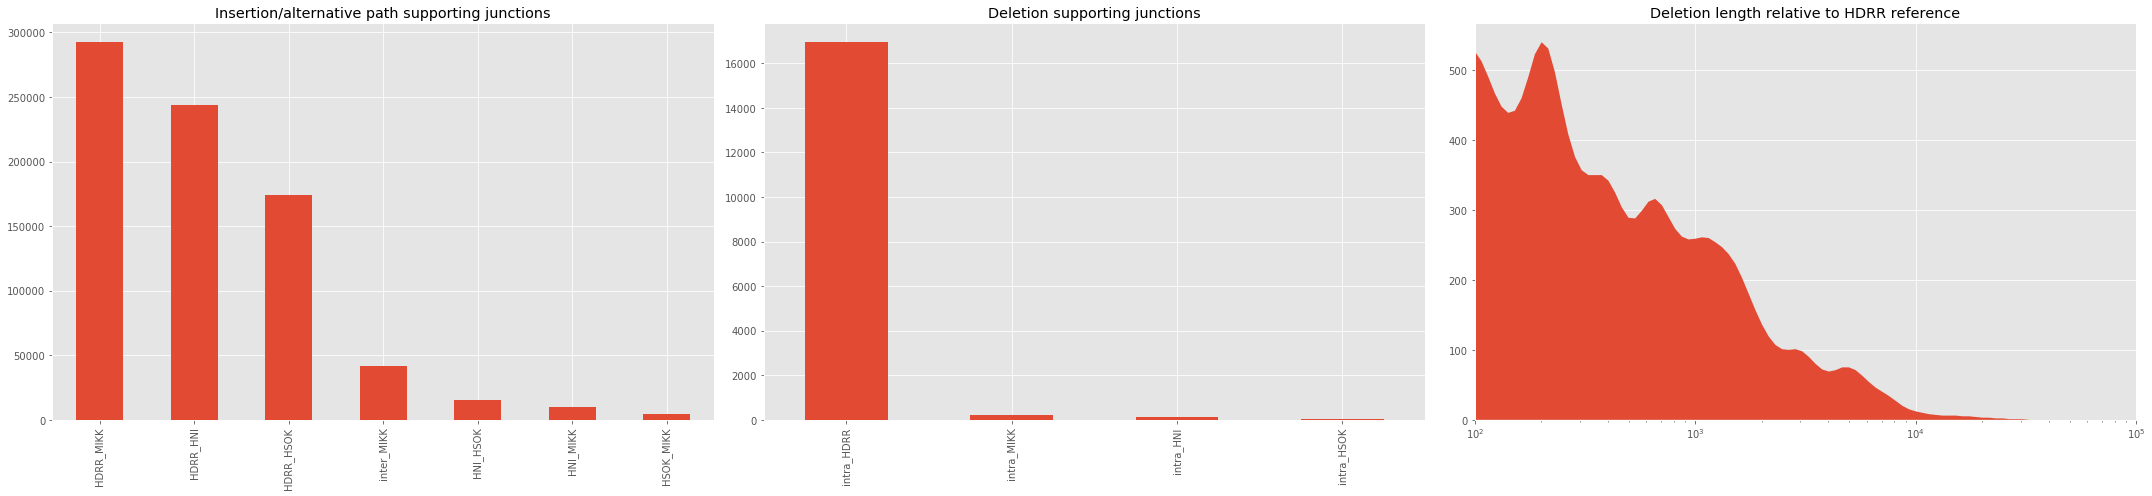

In [39]:
from scipy.ndimage import gaussian_filter1d

link_info_fn = "./graph_assembly/all_ref_graph_link_info.pkl"
df = pd.read_pickle(link_info_fn)
df = df[df["connect_type"].isin(["HDRR_MIKK", "HDRR_HNI", "HDRR_HSOK", "HNI_HSOK", "HNI_MIKK", "HSOK_MIKK", "intra_HDRR", "intra_MIKK", "intra_HNI", "intra_HSOK", "inter_HDRR", "inter_MIKK", "inter_HNI", "inter_HSOK"])]
display(df.head())

with pl.style.context('ggplot'):

    fig, (ax1, ax2, ax3) = pl.subplots(1, 3, figsize=(30 ,7))

    ins_df = df[df["SV_type"]=="insertion"]
    s = ins_df["connect_type"].value_counts()
    s.plot.bar(ax=ax1)
    ax1.set_title('Insertion/alternative path supporting junctions')

    del_df = df[df["SV_type"]=="deletion"]
    s = del_df["connect_type"].value_counts()
    s.plot.bar(ax=ax2)
    ax2.set_title('Deletion supporting junctions')

    hdrr_del = df[df["connect_type"]=="intra_HDRR"]
    
    # Process data for plot
    x = list(np.logspace(2,5,100))
    y = np.histogram((hdrr_del["connect_gap"]), bins=x+[10e6])[0]
    y = gaussian_filter1d (y, sigma=2)
    ax3.fill_betweenx(y=y, x1=x)
    ax3.set_xlim(1e2,1e5)
    ax3.set_ylim(0, None)
    ax3.set_xscale('log')
    ax3.set_title('Deletion length relative to HDRR reference')
    
    fig.tight_layout()

### Identity stats

Counts by category


,HDRR,HNI,HSOK,MIKK
Short low divergence,45.0,44305,35018,81069
Long low divergence,3.0,6935,8179,39013
Short high divergence,8.0,26900,14084,24517
Long high divergence,0.0,4184,9239,10457


% by category


,HDRR,HNI,HSOK,MIKK
Short low divergence,80.357143,53.817842,52.642814,52.283691
Long low divergence,5.357143,8.424032,12.295550,25.160587
Short high divergence,14.285714,32.675769,21.172580,15.811707
Long high divergence,0.000000,5.082358,13.889056,6.744015


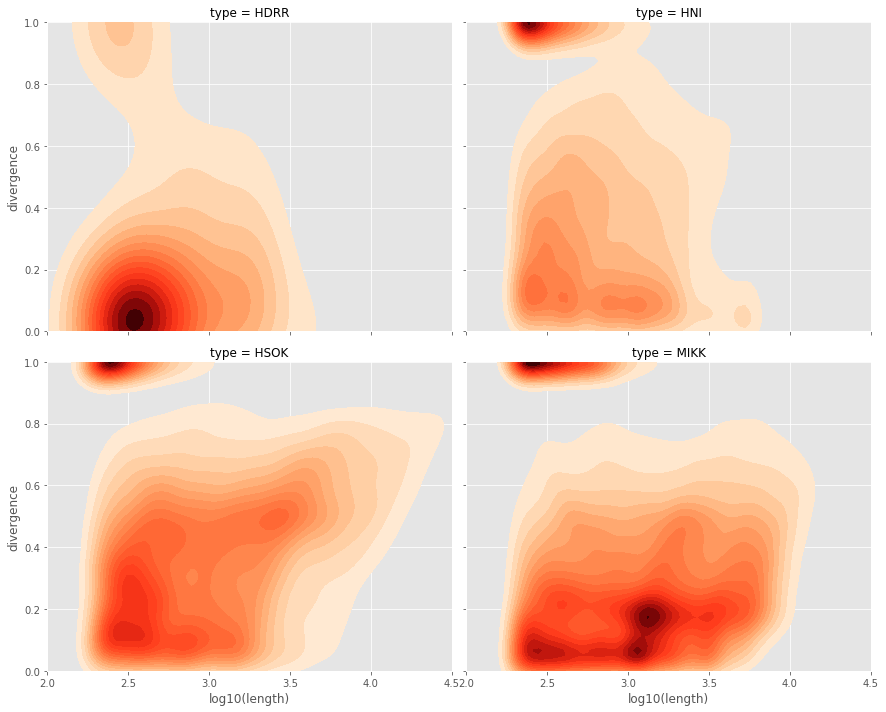

In [335]:
graph_info_fn = "./graph_assembly/all_ref_graph_seg_info.pkl"
svg_out_fn =  "./graph_assembly/identity_len_stats.svg"
min_long = 2000
min_divergent = 0.5

graph_info_df = pd.read_pickle(graph_info_fn)
graph_info_df = graph_info_df[["type", "length", "identity"]]
graph_info_df["type"] = graph_info_df["type"].str.rstrip("+")

graph_info_df = graph_info_df.dropna ()
#graph_info_df = graph_info_df.sample(20000) ###############################

graph_info_df["log10(length)"] = np.log10(graph_info_df["length"])
graph_info_df["divergence"] = 1-graph_info_df["identity"] 

d = defaultdict(Counter)
for line in graph_info_df.itertuples():
#     if line.divergence == 1:
#         d[line.type]["Fully divergent"] += 1
    if line.divergence >= min_divergent and line.length >= min_long:
        d[line.type]["Long high divergence"] += 1
    elif line.divergence >= min_divergent and line.length < min_long:
        d[line.type]["Short high divergence"] += 1
    elif line.divergence < min_divergent and line.length >= min_long:
        d[line.type]["Long low divergence"] += 1
    elif line.divergence < min_divergent and line.length < min_long:
        d[line.type]["Short low divergence"] += 1

print("Counts by category")
df = pd.DataFrame(d)
df = df.fillna(0)
display(df)

print("% by category")
df = df/df.sum(axis=0)*100
display(df)

with pl.style.context('ggplot'):
    cmap = sns.cubehelix_palette(start=0.9, rot=0.1, dark=0.01, light=0.99, hue=2.75, gamma=0.75, as_cmap=True)
    g = sns.FacetGrid(graph_info_df, col="type", col_wrap=2, height=5, aspect=1.25)
    g = g.map(sns.kdeplot, "log10(length)", "divergence", shade=True, shade_lowest=False, cmap=cmap, n_levels=20)
    
    for ax in g.axes:
        ax.set_ylim(0, 1)
        ax.set_xlim(2, 4.5)
        
    g.savefig(svg_out_fn)

### Get component stats

In [22]:
 def segment_type_stats (graph_info_fn, canonical_fa_fn, outdir):
    
    graph_info_df = pd.read_pickle(graph_info_fn)

    # Group segments by component
    components_dict = defaultdict(Component)
    for seg_id, seg_info in tqdm(zip(graph_info_df.index, graph_info_df.itertuples()), total=len(graph_info_df)):
        components_dict[seg_info.component].add(seg_id=seg_id, seg_info=seg_info)
    
    canonical_len_d = OrderedDict()
    with pyfaidx.Fasta(canonical_fa_fn) as fa:
        for seq in fa:
            canonical_len_d[seq.name] = len(seq)
    
    comp_len_d = OrderedDict()
    comp_ratio_d = OrderedDict()
    comp_num_d = OrderedDict()
    for i, j in components_dict.items():
        chrom = j.main_chromosome
        comp_len_d[chrom] = {"Canonical chromosomes":canonical_len_d[chrom], "Graph segments":j.length}
        comp_ratio_d[chrom] = j.length/canonical_len_d[chrom]
        comp_num_d[chrom]=len(j.segments)
        
    comp_len_df = pd.DataFrame.from_dict(comp_len_d, orient="index")
    comp_ratio_df = pd.DataFrame.from_dict(comp_ratio_d, orient="index", columns=["Ratio canonical/graph"])
    comp_num_df = pd.DataFrame.from_dict(comp_num_d, orient="index", columns=["Number of segments"])
    
    with pl.style.context('ggplot'):
        fig, (ax1, ax2, ax3) = pl.subplots(3, 1, figsize=(20,15))

        comp_len_df.plot.bar(ax=ax1, color=("steelblue","tomato"), legend=True)
        table(ax1, comp_len_df, colWidths=[0.10]*2, colLoc="center", cellLoc="center", fontsize=14, bbox=(1.15,0,0.2,1))
        ax1.set_title('Length of canonical chromosomes')
        ax1.set_ylabel("Length")
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
        
        comp_ratio_df.plot.bar(ax=ax2, color="tomato", legend=False)
        table(ax2, comp_ratio_df, colWidths=[0.10], colLoc="center", cellLoc="center", fontsize=14, bbox=(1.15,0,0.2,1))
        ax2.set_title('Ratio of Graph segment length by canonical chromosome length')
        ax2.set_ylabel("Length ratio")
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

        comp_num_df.plot.bar(ax=ax3, color="steelblue", legend=False)
        table(ax3, comp_num_df, colWidths=[0.10], colLoc="center", cellLoc="center", fontsize=14, bbox=(1.15,0,0.2,1))
        ax3.set_title('Number of graph segments per chromosome')
        ax3.set_ylabel("Number of segments")
        ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
        
        fig.tight_layout()
        out_fn = os.path.join(outdir, "component_stats.svg")
        fig.savefig(out_fn)
        
# Helper class to store component information
class Component():

    def __init__ (self):
        self.segments = list()
        self.chromosomes = Counter()
        self.length = 0
    
    def add (self, seg_id, seg_info):
        self.segments.append(seg_id)
        self.chromosomes[seg_info.chromosome]+=1
        self.length += seg_info.length
    
    def __repr__ (self):
        return f"Segments: {len(self.segments)}, chromomomes: {len(self.chromosomes)}, Length: {self.length}, Main chromosome: {self.main_chromosome}"
    
    @property
    def main_chromosome(self):
        return self.chromosomes.most_common(1)[0][0]

100%|██████████| 1109492/1109492 [00:07<00:00, 149790.83it/s]


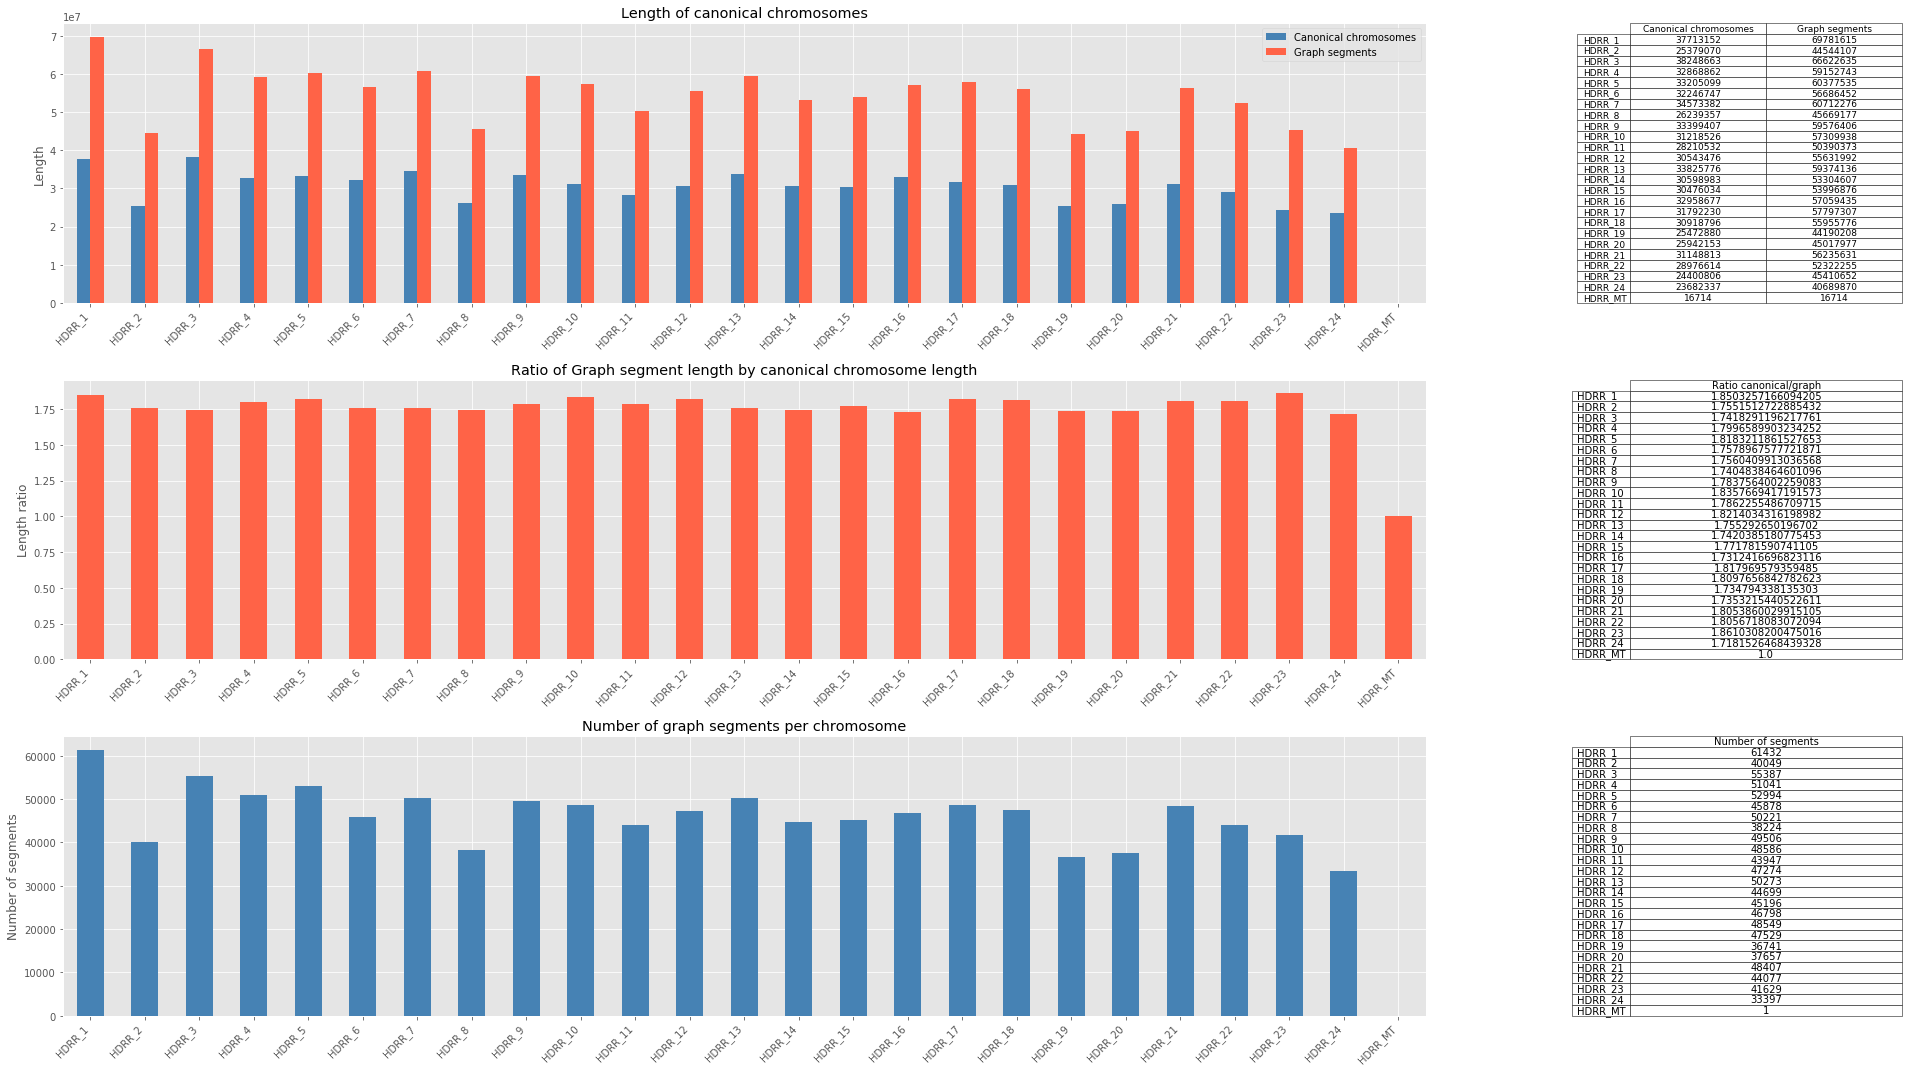

In [24]:
segment_type_stats("./graph_assembly/all_ref_graph_seg_info.pkl", "./references/Oryzias_latipes_HDRR_clean.fa", outdir="./graph_assembly/")

### Make graph info file for Bandage 

In [31]:
graph_info_fn = "./graph_assembly/all_ref_graph_info.pkl"
bandage_info_type = "./graph_assembly/all_ref_graph_type_bandage.csv"
bandage_info_identity = "./graph_assembly/all_ref_graph_identity_bandage.csv"
ref_type = "HDRR"

graph_info_df = pd.read_pickle(graph_info_fn) 
graph_info_df.index.name="Name"
graph_info_df = graph_info_df.drop(columns=["start", "end", "hit_start", "hit_end", "component", "connected_forward", "connected_reverse"])

#Define colormap
type_list = ['HDRR', 'HDRR+', 'HNI', 'HNI+', 'HSOK', 'HSOK+', 'MIKK']
type_color_dict = OrderedDict()
for col, lab in zip(sns.color_palette('tab20', len(type_list)), type_list):
    type_color_dict[lab] = rgb2hex(col)

#Define colormap
no_data_color = "#535353"
identity_thresholds = [0, 0.25, 0.5, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
identity_color_dict = OrderedDict()
for col, lab in zip(sns.color_palette('afmhot', len(identity_thresholds)), identity_thresholds):
    identity_color_dict[lab] = rgb2hex(col)
    
type_color_list = []
identity_color_list = []

for line in tqdm(graph_info_df.itertuples(), total=len(graph_info_df)):
    type_color_list.append(type_color_dict[line.type])
    if pd.isna(line.identity):
          identity_color_list.append(no_data_color)
    else:
        for threshold, color in identity_color_dict.items():
            if line.identity<=threshold:
                identity_color_list.append(color)
                break

graph_info_type_df = graph_info_df.copy()
graph_info_type_df["Color"] = type_color_list
graph_info_type_df.to_csv(bandage_info_type, sep=",")
display(graph_info_type_df.sample(5))

graph_info_identity_df = graph_info_df.copy()
graph_info_identity_df["Color"] = identity_color_list
graph_info_identity_df.to_csv(bandage_info_identity, sep=",")
display(graph_info_identity_df.sample(5))

100%|██████████| 1109492/1109492 [00:02<00:00, 448054.18it/s]


,chromosome,length,type,identity,hit_chromosome,Color
Name,,,,,,
s1059479,MIKK_79-2_G3_275,201,MIKK,NaN,None,#d62728
s275553,HDRR_10,1660,HDRR,NaN,None,#1f77b4
s947382,MIKK_69-1_F3_989,1132,MIKK,0.936752,HDRR_13,#d62728
s76794,HDRR_3,255,HDRR,NaN,None,#1f77b4
s105291,HDRR_4,29,HDRR,NaN,None,#1f77b4


,chromosome,length,type,identity,hit_chromosome,Color
Name,,,,,,
s38779,HDRR_2,118,HDRR,NaN,None,#535353
s203698,HDRR_7,58,HDRR,NaN,None,#535353
s416004,HDRR_15,1431,HDRR,NaN,None,#535353
s830100,HSOK_8,3926,HSOK,0.89781,HDRR_9,#ffe667
s645664,HDRR_24,226,HDRR,NaN,None,#535353


### Make all segment bed track for IGV

In [98]:
graph_info_fn = "./graph_assembly/all_ref_graph_info.pkl"
bed_out = "./graph_assembly/all_ref_graph_segments.bed"
bed_out_sorted = "./graph_assembly/all_ref_graph_segments_sorted.bed"

graph_info_df = pd.read_pickle(graph_info_fn) 
graph_info_df = graph_info_df.reset_index()
graph_info_df = graph_info_df[["chromosome", "start", "end", "seg_id"]]
graph_info_df.to_csv(bed_out, sep="\t", index=False, header=False)

print(f"Sort and index with igvtools")
bash (f"igvtools sort {bed_out} {bed_out_sorted}", conda="IGV")
bash (f"igvtools index {bed_out_sorted}", conda="IGV")

# Remove originals
os.remove(bed_out)

Sort and index with igvtools
Using system JDK.
WARN [2020-07-08T10:34:01,104]  [Globals.java:138] [main]  Development mode is enabled
Sorting ./graph_assembly2/all_ref_graph_segments.bed  -> ./graph_assembly2/all_ref_graph_segments_sorted.bed
Done
Using system JDK.
WARN [2020-07-08T10:35:15,988]  [Globals.java:138] [main]  Development mode is enabled
Done


## Align to graph

In [ ]:
outdir = "alignments2"
shutil.rmtree(outdir, ignore_errors=True)
mkdir(outdir)

### Align raw reads to graph

In [10]:
outdir = "alignments2/raw_reads"
shutil.rmtree(outdir, ignore_errors=True)
mkdir(outdir)

wait_jobid = "3595722"
dry=False
graph = "./graph_assembly/all_ref_graph.gfa"

for fasta in glob.glob("/hps/research1/birney/users/adrien/analyses/medaka_DNA_promethion/brain_run2/DNA_pipeline5/results/input/merged_fastq/*.fastq"):
    sample_id = os.path.basename(fasta).split(".")[0]
    print (f"Aligning sample {sample_id}")
    
    # Normal mode
    gaf = f"{outdir}/{sample_id}_stable.gaf"
    stdout = f"{outdir}/{sample_id}_stable.out"
    stderr = f"{outdir}/{sample_id}_stable.err"
    bsub(f"minigraph -x lr -t 10 {graph} {fasta} -o {gaf}", conda="minigraph", dry=dry, wait_jobid=wait_jobid, mem=30000, threads=10, stdout_fp=stdout, stderr_fp=stderr)
    
    # Unstable ref mapping mode
    gaf = f"{outdir}/{sample_id}_unstable.gaf"
    stdout = f"{outdir}/{sample_id}_unstable.out"
    stderr = f"{outdir}/{sample_id}_unstable.err"
    bsub(f"minigraph -x lr --vc -t 10 {graph} {fasta} -o {gaf}", conda="minigraph", dry=dry, wait_jobid=wait_jobid, mem=30000, threads=10, stdout_fp=stdout, stderr_fp=stderr)

Creating /hps/research1/birney/users/adrien/analyses/medaka_assembly_graph/graph_explore/alignments2/raw_reads
Aligning sample 4-2_B2
bsub -M 30000 -R 'rusage[mem=30000]' -n 10 -oo alignments2/raw_reads/4-2_B2_stable.out -eo alignments2/raw_reads/4-2_B2_stable.err -w 'post_done(3595722)'  "minigraph -x lr -t 10 ./graph_assembly2/all_ref_graph.gfa /hps/research1/birney/users/adrien/analyses/medaka_DNA_promethion/brain_run2/DNA_pipeline5/results/input/merged_fastq/4-2_B2.fastq -o alignments2/raw_reads/4-2_B2_stable.gaf"
Job <3768120> is submitted to default queue <research-rh74>.
bsub -M 30000 -R 'rusage[mem=30000]' -n 10 -oo alignments2/raw_reads/4-2_B2_unstable.out -eo alignments2/raw_reads/4-2_B2_unstable.err -w 'post_done(3595722)'  "minigraph -x lr --vc -t 10 ./graph_assembly2/all_ref_graph.gfa /hps/research1/birney/users/adrien/analyses/medaka_DNA_promethion/brain_run2/DNA_pipeline5/results/input/merged_fastq/4-2_B2.fastq -o alignments2/raw_reads/4-2_B2_unstable.gaf"
Job <3768121> 

Job <3768148> is submitted to default queue <research-rh74>.
Aligning sample 131-1_F4
bsub -M 30000 -R 'rusage[mem=30000]' -n 10 -oo alignments2/raw_reads/131-1_F4_stable.out -eo alignments2/raw_reads/131-1_F4_stable.err -w 'post_done(3595722)'  "minigraph -x lr -t 10 ./graph_assembly2/all_ref_graph.gfa /hps/research1/birney/users/adrien/analyses/medaka_DNA_promethion/brain_run2/DNA_pipeline5/results/input/merged_fastq/131-1_F4.fastq -o alignments2/raw_reads/131-1_F4_stable.gaf"
Job <3768149> is submitted to default queue <research-rh74>.
bsub -M 30000 -R 'rusage[mem=30000]' -n 10 -oo alignments2/raw_reads/131-1_F4_unstable.out -eo alignments2/raw_reads/131-1_F4_unstable.err -w 'post_done(3595722)'  "minigraph -x lr --vc -t 10 ./graph_assembly2/all_ref_graph.gfa /hps/research1/birney/users/adrien/analyses/medaka_DNA_promethion/brain_run2/DNA_pipeline5/results/input/merged_fastq/131-1_F4.fastq -o alignments2/raw_reads/131-1_F4_unstable.gaf"
Job <3768152> is submitted to default queue <r

### Align individual assembly to graph

In [13]:
outdir = "alignments2/assemblies"
shutil.rmtree(outdir, ignore_errors=True)
mkdir(outdir)

wait_jobid = "3595722"
dry=False
graph = "./graph_assembly/all_ref_graph.gfa"

for fasta in glob.glob("./individual_assemblies/*_clean.fa"):
    sample_id = os.path.basename(fasta).split(".")[0].rstrip("_clean")
    print (f"Aligning sample {sample_id}")
    
    # Normal mode
    gaf = f"{outdir}/{sample_id}_stable.gaf"
    stdout = f"{outdir}/{sample_id}_stable.out"
    stderr = f"{outdir}/{sample_id}_stable.err"
    bsub(f"minigraph -x asm -t 10 {graph} {fasta} -o {gaf}", conda="minigraph", dry=dry, wait_jobid=wait_jobid, mem=30000, threads=10, stdout_fp=stdout, stderr_fp=stderr)
    
    # Unstable ref mapping mode
    gaf = f"{outdir}/{sample_id}_unstable.gaf"
    stdout = f"{outdir}/{sample_id}_unstable.out"
    stderr = f"{outdir}/{sample_id}_unstable.err"
    bsub(f"minigraph -x asm --vc -t 10 {graph} {fasta} -o {gaf}", conda="minigraph", dry=dry, wait_jobid=wait_jobid, mem=30000, threads=10, stdout_fp=stdout, stderr_fp=stderr)

Creating /hps/research1/birney/users/adrien/analyses/medaka_assembly_graph/graph_explore/alignments2/assemblies
Aligning sample 69-1_F3
bsub -M 30000 -R 'rusage[mem=30000]' -n 10 -oo alignments2/assemblies/69-1_F3_stable.out -eo alignments2/assemblies/69-1_F3_stable.err -w 'post_done(3595722)'  "minigraph -x asm -t 10 ./graph_assembly2/all_ref_graph.gfa ./individual_assemblies/69-1_F3_clean.fa -o alignments2/assemblies/69-1_F3_stable.gaf"
Job <3768182> is submitted to default queue <research-rh74>.
bsub -M 30000 -R 'rusage[mem=30000]' -n 10 -oo alignments2/assemblies/69-1_F3_unstable.out -eo alignments2/assemblies/69-1_F3_unstable.err -w 'post_done(3595722)'  "minigraph -x asm --vc -t 10 ./graph_assembly2/all_ref_graph.gfa ./individual_assemblies/69-1_F3_clean.fa -o alignments2/assemblies/69-1_F3_unstable.gaf"
Job <3768183> is submitted to default queue <research-rh74>.
Aligning sample 131-1_F4
bsub -M 30000 -R 'rusage[mem=30000]' -n 10 -oo alignments2/assemblies/131-1_F4_stable.out -e

Job <3768211> is submitted to default queue <research-rh74>.
Aligning sample 11-1_A3
bsub -M 30000 -R 'rusage[mem=30000]' -n 10 -oo alignments2/assemblies/11-1_A3_stable.out -eo alignments2/assemblies/11-1_A3_stable.err -w 'post_done(3595722)'  "minigraph -x asm -t 10 ./graph_assembly2/all_ref_graph.gfa ./individual_assemblies/11-1_A3_clean.fa -o alignments2/assemblies/11-1_A3_stable.gaf"
Job <3768212> is submitted to default queue <research-rh74>.
bsub -M 30000 -R 'rusage[mem=30000]' -n 10 -oo alignments2/assemblies/11-1_A3_unstable.out -eo alignments2/assemblies/11-1_A3_unstable.err -w 'post_done(3595722)'  "minigraph -x asm --vc -t 10 ./graph_assembly2/all_ref_graph.gfa ./individual_assemblies/11-1_A3_clean.fa -o alignments2/assemblies/11-1_A3_unstable.gaf"
Job <3768213> is submitted to default queue <research-rh74>.


### Align Illumina RNA-Seq datasets to graph

In [14]:
outdir = "alignments2/rna_seq"
shutil.rmtree(outdir, ignore_errors=True)
mkdir(outdir)

wait_jobid = "3595722"
dry=False
graph = "./graph_assembly/all_ref_graph.gfa"

for fasta in glob.glob("rna_seq_data/*_merged.extendedFrags.fastq.gz"):
    sample_id = os.path.basename(fasta).split("_")[0]
    print (f"Aligning sample {sample_id}")
    
    # Normal mode
    gaf = f"{outdir}/{sample_id}_stable.gaf"
    stdout = f"{outdir}/{sample_id}_stable.out"
    stderr = f"{outdir}/{sample_id}_stable.err"
    bsub(f"minigraph -x sr -t 10 {graph} {fasta} -o {gaf}", conda="minigraph", dry=dry, wait_jobid=wait_jobid, mem=15000, threads=10, stdout_fp=stdout, stderr_fp=stderr)

    # Unstable ref mapping mode
    gaf = f"{outdir}/{sample_id}_unstable.gaf"
    stdout = f"{outdir}/{sample_id}_unstable.out"
    stderr = f"{outdir}/{sample_id}_unstable.err"
    bsub(f"minigraph -x sr --vc -t 10 {graph} {fasta} -o {gaf}", conda="minigraph", dry=dry, wait_jobid=wait_jobid, mem=15000, threads=10, stdout_fp=stdout, stderr_fp=stderr)

Creating /hps/research1/birney/users/adrien/analyses/medaka_assembly_graph/graph_explore/alignments2/rna_seq
Aligning sample 95-1
bsub -M 15000 -R 'rusage[mem=15000]' -n 10 -oo alignments2/rna_seq/95-1_stable.out -eo alignments2/rna_seq/95-1_stable.err -w 'post_done(3595722)'  "minigraph -x sr -t 10 ./graph_assembly2/all_ref_graph.gfa rna_seq_data/95-1_merged.extendedFrags.fastq.gz -o alignments2/rna_seq/95-1_stable.gaf"
Job <3768234> is submitted to default queue <research-rh74>.
bsub -M 15000 -R 'rusage[mem=15000]' -n 10 -oo alignments2/rna_seq/95-1_unstable.out -eo alignments2/rna_seq/95-1_unstable.err -w 'post_done(3595722)'  "minigraph -x sr --vc -t 10 ./graph_assembly2/all_ref_graph.gfa rna_seq_data/95-1_merged.extendedFrags.fastq.gz -o alignments2/rna_seq/95-1_unstable.gaf"
Job <3768235> is submitted to default queue <research-rh74>.
Aligning sample 94-1
bsub -M 15000 -R 'rusage[mem=15000]' -n 10 -oo alignments2/rna_seq/94-1_stable.out -eo alignments2/rna_seq/94-1_stable.err -w 

Job <3768261> is submitted to default queue <research-rh74>.
Aligning sample 61-1
bsub -M 15000 -R 'rusage[mem=15000]' -n 10 -oo alignments2/rna_seq/61-1_stable.out -eo alignments2/rna_seq/61-1_stable.err -w 'post_done(3595722)'  "minigraph -x sr -t 10 ./graph_assembly2/all_ref_graph.gfa rna_seq_data/61-1_merged.extendedFrags.fastq.gz -o alignments2/rna_seq/61-1_stable.gaf"
Job <3768262> is submitted to default queue <research-rh74>.
bsub -M 15000 -R 'rusage[mem=15000]' -n 10 -oo alignments2/rna_seq/61-1_unstable.out -eo alignments2/rna_seq/61-1_unstable.err -w 'post_done(3595722)'  "minigraph -x sr --vc -t 10 ./graph_assembly2/all_ref_graph.gfa rna_seq_data/61-1_merged.extendedFrags.fastq.gz -o alignments2/rna_seq/61-1_unstable.gaf"
Job <3768263> is submitted to default queue <research-rh74>.
Aligning sample 59-2
bsub -M 15000 -R 'rusage[mem=15000]' -n 10 -oo alignments2/rna_seq/59-2_stable.out -eo alignments2/rna_seq/59-2_stable.err -w 'post_done(3595722)'  "minigraph -x sr -t 10 ./g

Aligning sample 32-2
bsub -M 15000 -R 'rusage[mem=15000]' -n 10 -oo alignments2/rna_seq/32-2_stable.out -eo alignments2/rna_seq/32-2_stable.err -w 'post_done(3595722)'  "minigraph -x sr -t 10 ./graph_assembly2/all_ref_graph.gfa rna_seq_data/32-2_merged.extendedFrags.fastq.gz -o alignments2/rna_seq/32-2_stable.gaf"
Job <3768284> is submitted to default queue <research-rh74>.
bsub -M 15000 -R 'rusage[mem=15000]' -n 10 -oo alignments2/rna_seq/32-2_unstable.out -eo alignments2/rna_seq/32-2_unstable.err -w 'post_done(3595722)'  "minigraph -x sr --vc -t 10 ./graph_assembly2/all_ref_graph.gfa rna_seq_data/32-2_merged.extendedFrags.fastq.gz -o alignments2/rna_seq/32-2_unstable.gaf"
Job <3768286> is submitted to default queue <research-rh74>.
Aligning sample 30-1
bsub -M 15000 -R 'rusage[mem=15000]' -n 10 -oo alignments2/rna_seq/30-1_stable.out -eo alignments2/rna_seq/30-1_stable.err -w 'post_done(3595722)'  "minigraph -x sr -t 10 ./graph_assembly2/all_ref_graph.gfa rna_seq_data/30-1_merged.ext

Aligning sample 13-2
bsub -M 15000 -R 'rusage[mem=15000]' -n 10 -oo alignments2/rna_seq/13-2_stable.out -eo alignments2/rna_seq/13-2_stable.err -w 'post_done(3595722)'  "minigraph -x sr -t 10 ./graph_assembly2/all_ref_graph.gfa rna_seq_data/13-2_merged.extendedFrags.fastq.gz -o alignments2/rna_seq/13-2_stable.gaf"
Job <3768313> is submitted to default queue <research-rh74>.
bsub -M 15000 -R 'rusage[mem=15000]' -n 10 -oo alignments2/rna_seq/13-2_unstable.out -eo alignments2/rna_seq/13-2_unstable.err -w 'post_done(3595722)'  "minigraph -x sr --vc -t 10 ./graph_assembly2/all_ref_graph.gfa rna_seq_data/13-2_merged.extendedFrags.fastq.gz -o alignments2/rna_seq/13-2_unstable.gaf"
Job <3768315> is submitted to default queue <research-rh74>.
Aligning sample 139-4
bsub -M 15000 -R 'rusage[mem=15000]' -n 10 -oo alignments2/rna_seq/139-4_stable.out -eo alignments2/rna_seq/139-4_stable.err -w 'post_done(3595722)'  "minigraph -x sr -t 10 ./graph_assembly2/all_ref_graph.gfa rna_seq_data/139-4_merged

Job <3768339> is submitted to default queue <research-rh74>.
Aligning sample 11-2
bsub -M 15000 -R 'rusage[mem=15000]' -n 10 -oo alignments2/rna_seq/11-2_stable.out -eo alignments2/rna_seq/11-2_stable.err -w 'post_done(3595722)'  "minigraph -x sr -t 10 ./graph_assembly2/all_ref_graph.gfa rna_seq_data/11-2_merged.extendedFrags.fastq.gz -o alignments2/rna_seq/11-2_stable.gaf"
Job <3768340> is submitted to default queue <research-rh74>.
bsub -M 15000 -R 'rusage[mem=15000]' -n 10 -oo alignments2/rna_seq/11-2_unstable.out -eo alignments2/rna_seq/11-2_unstable.err -w 'post_done(3595722)'  "minigraph -x sr --vc -t 10 ./graph_assembly2/all_ref_graph.gfa rna_seq_data/11-2_merged.extendedFrags.fastq.gz -o alignments2/rna_seq/11-2_unstable.gaf"
Job <3768341> is submitted to default queue <research-rh74>.
Aligning sample 117-2
bsub -M 15000 -R 'rusage[mem=15000]' -n 10 -oo alignments2/rna_seq/117-2_stable.out -eo alignments2/rna_seq/117-2_stable.err -w 'post_done(3595722)'  "minigraph -x sr -t 10 

## Generate coverage BED 

In [7]:
outdir = "coverage2"
shutil.rmtree(outdir, ignore_errors=True)
mkdir (outdir)

Creating /hps/research1/birney/users/adrien/analyses/medaka_assembly_graph/graph_explore/coverage2


### Define parsing function 

In [10]:
def split_path (path):
    l = []
    s = ""
    for c in path:
        if s and c in ["<", ">"]:
            l.append(s)
            s = c
        else:
            s+=c
    if s: 
        l.append(s)
    return l

def parse_stable_gaf (gaf_fn, min_align_len=100, min_mapq=10, progress=True):
    
    with open (gaf_fn) as gaf_fp:
        c = Counter()
        l = []
        
        coord_tuple = namedtuple("coord_tuple", ("chromosome", "start", "end"))
        for line in tqdm(gaf_fp, disable=not progress):
            line = line.strip().split("\t")
            align_len = int(line[10])
            mapq = int(line[11])
            align_type = line[12].split(":")[-1]

            if align_len < min_align_len:
                c["Short length alignments"]+=1
                continue
            if mapq < min_mapq:
                c["Low mapq alignments"]+=1
                continue
            if align_type != "P":
                c["Non primary alignments"]+=1
                continue
            
            # Decompose path from
            c["Valid reads"]+=1
            for p in split_path(line[5]):
                
                if p[0] in ["<", ">"]:
                    chromosome = p[1:].split(":")[0]
                    start = int(p.split(":")[1].split("-")[0])
                    end = int(p.split(":")[1].split("-")[1])
                    #strand = "+" if node[0] == ">" else "-"
                                        
                else:
                    chromosome = p
                    start = int(line[7])
                    end = int(line[8])
                    #strand = line[4]
                
                c["Valid segments"]+=1
                l.append(coord_tuple(chromosome, start, end))
    
    for i, j in c.items():
        stdout_print(f"\t\t{i}: {j}\n")
    
    df = pd.DataFrame(l)
    df.sort_values(by=["chromosome", "start", "end"], inplace=True)
    df.reset_index(inplace=True, drop=True)
        
    return df

def coverage_from_gaf (gaf_src, all_fasta_ref, outdir, min_align_len=100, min_mapq=1):
    
    stdout_print("Define chromosome length for pybedtools\n")
    chrom_len = OrderedDict()
    with pyfaidx.Fasta(all_fasta_ref) as fa:
        for seq in fa:
            chrom_len[str(seq.name)]=(0, len(seq))
    
    stdout_print("Parsing gaf files\n")
    for gaf_fn in glob.glob(gaf_src):
        sample_id = gaf_fn.split("/")[-1].rpartition("_")[0]

        stdout_print(f"Analyse sample {sample_id}\n")
        
        stdout_print("\tCollect coordinates from paths\n")
        bed_df = parse_stable_gaf (gaf_fn, min_align_len=min_align_len, min_mapq=min_mapq, progress=False)
        bed_fn = os.path.join(outdir, f"{sample_id}.bed")
        bed_df.to_csv(bed_fn, index=False, header=False, sep="\t")

        stdout_print("\tCompute coverage with bedtools\n")
        bedgraph_fn = os.path.join(outdir, f"{sample_id}.bedgraph")
        bed = pbt.BedTool(bed_fn)
        bed.set_chromsizes(chrom_len)
        bg = bed.genomecov(bg=True, split=True, trackopts=f'type=bedGraph name={sample_id}')
        bg.saveas(bedgraph_fn)

### Assemblies

In [12]:
outdir = "coverage2/assemblies"
shutil.rmtree(outdir, ignore_errors=True)
mkdir (outdir)

coverage_from_gaf(
    gaf_src = "./alignments2/assemblies/*_stable.gaf", 
    all_fasta_ref = "./references/Oryzias_latipes_all_assemblies_contig.fa",
    outdir = outdir,
    min_align_len=100,
    min_mapq=1)

Creating /hps/research1/birney/users/adrien/analyses/medaka_assembly_graph/graph_explore/coverage2/assemblies
Define chromosome length for pybedtools
Parsing gaf files
Analyse sample 11-1_A3
	Collect coordinates from paths
		Valid reads: 4737
		Valid segments: 142732
		Low mapq alignments: 30
	Compute coverage with bedtools
Analyse sample 7-1_E2
	Collect coordinates from paths
		Valid reads: 4664
		Valid segments: 140450
		Low mapq alignments: 48
	Compute coverage with bedtools
Analyse sample 80-1_H3
	Collect coordinates from paths
		Valid reads: 5412
		Valid segments: 146056
		Low mapq alignments: 27
	Compute coverage with bedtools
Analyse sample 134-1_H4
	Collect coordinates from paths
		Valid reads: 4990
		Valid segments: 140290
		Low mapq alignments: 41
	Compute coverage with bedtools
Analyse sample 79-2_G3
	Collect coordinates from paths
		Valid reads: 4606
		Valid segments: 139154
		Low mapq alignments: 43
	Compute coverage with bedtools
Analyse sample 134-2_A5
	Collect coordinat

### Raw reads

In [14]:
outdir = "coverage2/raw_reads"
shutil.rmtree(outdir, ignore_errors=True)
mkdir (outdir)

coverage_from_gaf(
    gaf_src = "./alignments2/raw_reads/*_stable.gaf", 
    all_fasta_ref = "./references/Oryzias_latipes_all_assemblies_contig.fa",
    outdir = outdir)

Creating /hps/research1/birney/users/adrien/analyses/medaka_assembly_graph/graph_explore/coverage2/raw_reads
Define chromosome length for pybedtools
Parsing gaf files
Analyse sample 80-1_H3
	Collect coordinates from paths
		Valid reads: 2917291
		Valid segments: 4919369
		Low mapq alignments: 83469
		Short length alignments: 29408
	Compute coverage with bedtools
Analyse sample 134-2_A5
	Collect coordinates from paths
		Valid reads: 6777334
		Valid segments: 11408909
		Low mapq alignments: 194759
		Short length alignments: 81989
	Compute coverage with bedtools
Analyse sample 131-1_F4
	Collect coordinates from paths
		Valid reads: 6094598
		Valid segments: 11267278
		Low mapq alignments: 171111
		Short length alignments: 70168
	Compute coverage with bedtools
Analyse sample 7-2_F2
	Collect coordinates from paths
		Valid reads: 4608657
		Valid segments: 7788221
		Low mapq alignments: 127989
		Short length alignments: 51098
	Compute coverage with bedtools
Analyse sample 7-1_E2
	Collect coor

### RNA-Seq

In [15]:
outdir = "coverage2/rna_seq"
shutil.rmtree(outdir, ignore_errors=True)
mkdir (outdir)

coverage_from_gaf(
    gaf_src = "./alignments2/rna_seq/*_stable.gaf", 
    all_fasta_ref = "./references/Oryzias_latipes_all_assemblies_contig.fa",
    outdir = outdir)

Creating /hps/research1/birney/users/adrien/analyses/medaka_assembly_graph/graph_explore/coverage2/rna_seq
Define chromosome length for pybedtools
Parsing gaf files
Analyse sample 104-1
	Collect coordinates from paths
		Valid reads: 13273009
		Valid segments: 13465726
		Short length alignments: 4998346
		Low mapq alignments: 552162
	Compute coverage with bedtools
Analyse sample 106-1
	Collect coordinates from paths
		Valid reads: 14908961
		Valid segments: 15186000
		Low mapq alignments: 606541
		Short length alignments: 5931186
	Compute coverage with bedtools
Analyse sample 106-2
	Collect coordinates from paths
		Valid reads: 14505216
		Valid segments: 14586181
		Low mapq alignments: 536849
		Short length alignments: 5234146
	Compute coverage with bedtools
Analyse sample 10-1
	Collect coordinates from paths
		Valid reads: 12623419
		Valid segments: 12782983
		Short length alignments: 4945502
		Low mapq alignments: 468136
	Compute coverage with bedtools
Analyse sample 117-2
	Collect co

	Collect coordinates from paths
		Valid reads: 15508320
		Valid segments: 15632843
		Short length alignments: 6776940
		Low mapq alignments: 490659
	Compute coverage with bedtools
Analyse sample 71-1
	Collect coordinates from paths
		Valid reads: 13577377
		Valid segments: 13805382
		Short length alignments: 5384287
		Low mapq alignments: 539074
	Compute coverage with bedtools
Analyse sample 72-2
	Collect coordinates from paths
		Valid reads: 12669979
		Valid segments: 12766417
		Short length alignments: 4936910
		Low mapq alignments: 460648
	Compute coverage with bedtools
Analyse sample 79-2
	Collect coordinates from paths
		Valid reads: 14411069
		Valid segments: 14474574
		Short length alignments: 5290048
		Low mapq alignments: 527178
	Compute coverage with bedtools
Analyse sample 80-1
	Collect coordinates from paths
		Valid reads: 15351573
		Valid segments: 15477784
		Short length alignments: 5633655
		Low mapq alignments: 555289
	Compute coverage with bedtools
Analyse sample 84-2


## Coordinates to segments

### Find segment id of MIKK het regions

In [44]:
graph_info_fn = "./graph_assembly/all_ref_graph_seg_info.pkl"
het_coord_fn = "./extra/mikk_panel_proportion_het_across_genome_20200716.tsv"
het_coord_df = pd.read_csv(het_coord_fn, sep="\t")

,chromosome,start,end,length,type,identity,hit_chromosome,hit_start,hit_end,component,connected,connected_chromosome,connected_start,connected_end
seg_id,,,,,,,,,,,,,,
s1,HDRR_1,0,37816,37816,HDRR,NaN,None,NaN,NaN,1,"[s2, s1044544]",NaN,NaN,NaN
s2,HDRR_1,37816,37928,112,HDRR,NaN,None,NaN,NaN,1,"[s1, s3, s999575]",NaN,NaN,NaN
s3,HDRR_1,37928,40172,2244,HDRR,NaN,None,NaN,NaN,1,"[s2, s4]",NaN,NaN,NaN
s4,HDRR_1,40172,41595,1423,HDRR,NaN,None,NaN,NaN,1,"[s3, s5, s999575]",NaN,NaN,NaN
s5,HDRR_1,41595,50707,9112,HDRR,NaN,None,NaN,NaN,1,"[s4, s6, s1044544, s999574]",NaN,NaN,NaN


,chr,start,end,p_het
0,1,4156,14156,0.130435
1,1,14156,24156,1.000000
2,1,24156,34156,0.921739
3,1,34156,44156,0.895652
4,1,44156,54156,1.000000


In [119]:
import pybedtools as pbt

graph_info_fn = "./graph_assembly/all_ref_graph_seg_info.pkl"
het_coord_fn = "./extra/mikk_panel_proportion_het_across_genome_20200716.tsv"

stdout_print("Import coordinate file\n")
het_coord_df = pd.read_csv(het_coord_fn, sep="\t")
het_coord_df = het_coord_df[(het_coord_df["p_het"]==1)&(het_coord_df["chr"]!=1)]
het_coord_df = het_coord_df.drop_duplicates(ignore_index=True)
het_coord_df = het_coord_df.drop(columns=["p_het"])

stdout_print("Merge overlapping coordinates\n")
b = pbt.BedTool.from_dataframe(het_coord_df)
c = b.merge(d=10)
coord_df = c.to_dataframe()

stdout_print("Add length field and sort by length\n")
coord_df["length"] = coord_df["end"]-coord_df["start"]

stdout_print("Load graph info file\n")
graph_info_df = pd.read_pickle(graph_info_fn)
graph_info_df = graph_info_df[graph_info_df["type"]=="HDRR"]

stdout_print("Find id of segments overlapping each block \n")
start_seg_list = []
end_seg_list = []
n_seg_list = []
for line in coord_df.itertuples():
    start_seg = graph_info_df[(graph_info_df["component"]==line.chrom)&(line.start>=graph_info_df["start"])&(line.start<=graph_info_df["end"])].index[0]
    end_seg = graph_info_df[(graph_info_df["component"]==line.chrom)&(line.end>=graph_info_df["start"])&(line.end<=graph_info_df["end"])].index[0]
    n_seg = int(end_seg[1:]) - int(start_seg[1:])
    start_seg_list.append(start_seg)
    end_seg_list.append(end_seg)
    n_seg_list.append(n_seg)
coord_df["start_seg"] = start_seg_list
coord_df["end_seg"] = end_seg_list
coord_df["n_seg"] = n_seg_list
coord_df["n_seg_len"] = (coord_df["n_seg"]/coord_df["length"]*10000).astype(int)
coord_df = coord_df[(coord_df["n_seg_len"]>=15)] ################## Select messy regions
print(f"Found {len(coord_df)} intervals within required ranges")

coord_df["seg_list"] = coord_df["start_seg"]+","+coord_df["end_seg"]
coord_df["coord"] = coord_df["chrom"].astype(str)+":"+coord_df["start"].astype(str)+"-"+coord_df["end"].astype(str) 
coord_df

Import coordinate file
Merge overlapping coordinates
Add length field and sort by length
Load graph info file
Find id of segments overlapping each block 
Found 161 intervals within required ranges


,chrom,start,end,length,start_seg,end_seg,n_seg,n_seg_len,seg_list,coord
29,2,23180011,23190011,10000,s56815,s56837,22,22,"s56815,s56837",2:23180011-23190011
31,2,23730011,23750011,20000,s57642,s57674,32,16,"s57642,s57674",2:23730011-23750011
35,3,2330014,2340014,10000,s61243,s61258,15,15,"s61243,s61258",3:2330014-2340014
39,3,5770014,5810014,40000,s64617,s64682,65,16,"s64617,s64682",3:5770014-5810014
61,3,9100014,9120014,20000,s67699,s67730,31,15,"s67699,s67730",3:9100014-9120014
64,3,10190014,10200014,10000,s68600,s68617,17,17,"s68600,s68617",3:10190014-10200014
75,3,16940014,16950014,10000,s74253,s74268,15,15,"s74253,s74268",3:16940014-16950014
94,3,32560014,32570014,10000,s85836,s85852,16,16,"s85836,s85852",3:32560014-32570014
110,4,2750105,2760105,10000,s94065,s94089,24,23,"s94065,s94089",4:2750105-2760105
142,4,17040105,17060105,20000,s106415,s106449,34,17,"s106415,s106449",4:17040105-17060105


### Find segment id of LD decay regions

In [127]:
graph_info_fn = "./graph_assembly/all_ref_graph_seg_info.pkl"

coord_list = [
    (5,28181970,28970558),
    (6,29398579,32246747),
    (12,25336174,25384053),
    (14,12490842,12947083),
    (17,15557892,19561518),
    (21,6710074,7880374)]

res = namedtuple("res", ["chrom","start","end","length","start_seg","end_seg","n_seg","seg_list","coord"])

stdout_print("Load graph info file\n")
graph_info_df = pd.read_pickle(graph_info_fn)
graph_info_df = graph_info_df[graph_info_df["type"]=="HDRR"]

stdout_print("Find id of segments overlapping each block \n")
res_list = []

for chrom, start, end in coord_list:
    start_seg = graph_info_df[(graph_info_df["component"]==chrom)&(start>=graph_info_df["start"])&(start<=graph_info_df["end"])].index[0]
    end_seg = graph_info_df[(graph_info_df["component"]==chrom)&(end>=graph_info_df["start"])&(end<=graph_info_df["end"])].index[0]
    n_seg = int(end_seg[1:]) - int(start_seg[1:])
    seg_list = f"{start_seg},{end_seg}"
    coord = f"{chrom}:{start}-{end}" 
    res_list.append(res(chrom, start, end, end-start, start_seg, end_seg, n_seg, seg_list, coord))
    
pd.DataFrame(res_list)

Load graph info file
Find id of segments overlapping each block 


,chrom,start,end,length,start_seg,end_seg,n_seg,seg_list,coord
0,5,28181970,28970558,788588,s147321,s147889,568,"s147321,s147889",5:28181970-28970558
1,6,29398579,32246747,2848168,s176581,s179446,2865,"s176581,s179446",6:29398579-32246747
2,12,25336174,25384053,47879,s336317,s336387,70,"s336317,s336387",12:25336174-25384053
3,14,12490842,12947083,456241,s382112,s382516,404,"s382112,s382516",14:12490842-12947083
4,17,15557892,19561518,4003626,s465947,s469793,3846,"s465947,s469793",17:15557892-19561518
5,21,6710074,7880374,1170300,s557411,s558466,1055,"s557411,s558466",21:6710074-7880374
